## Hyperparameter tuning with a grid
- Create a grid of evenly spaced lat and lon
- Only keep grid points on the mainland
- Find the nearest city to the grid point
- Submit those lat+lon to the API
- See how results scale with number of cities submitted
- Try different zooms
- Try deeper pagination

In [1]:
import serpapi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

from dotenv import load_dotenv
import os
from tqdm.notebook import tqdm
import json
import scipy
from scipy.spatial import cKDTree
from mpl_toolkits.basemap import Basemap

## The goal is to plot the number of searches vs the number of results
- Trying to maximize number of quality results in minimum number of searches

## Import API key

In [2]:
# Load the environment variables from .env file
load_dotenv()

# Access the API key
serp_api_key = os.getenv('SERP_API_KEY')

if type(serp_api_key) == str and len(serp_api_key) > 0:
    print("SERP API KEY Loaded")
else:
    print("Error loading SERP API key")

SERP API KEY Loaded


## Start by collating list of FL cities

In [6]:
## Read in US zip code database (https://simplemaps.com/data/us-zips)
all_cities = pd.read_csv('Data/uszips.csv',dtype={'lat':str,'lng':str})
FL_cities = all_cities[all_cities['state_id']=='FL'].copy()

## Concatenate lat, long, and zoom for google maps search results
zoom = 12
FL_cities['Zoom'] = str(zoom)+'z'
FL_cities['ll'] = FL_cities.apply(lambda row: ','.join(row[['lat', 'lng', 'Zoom']]), axis=1).apply(lambda x: '@' + x)

## Sort by population and cast as int
FL_cities.sort_values(by='population', ascending=False, inplace=True)
FL_cities['population'] = FL_cities['population'].astype(int)
FL_cities.reset_index(inplace=True,drop=True)

## Drop unnecessary columns
FL_cities = FL_cities[['city','county_name','state_id','population','density','zip','lat','lng','Zoom','ll']]
FL_cities.rename(columns={'lng':'lon'},inplace=True)
FL_cities['lat'] = FL_cities['lat'].astype(float)
FL_cities['lon'] = FL_cities['lon'].astype(float)
FL_cities

,city,county_name,state_id,population,density,zip,lat,lon,Zoom,ll
0,Winter Garden,Orange,FL,81398,467.3,34787,28.48309,-81.62833,12z,"@28.48309,-81.62833,12z"
1,West Palm Beach,Palm Beach,FL,74923,830.0,33411,26.71517,-80.20305,12z,"@26.71517,-80.20305,12z"
2,Port Saint Lucie,St. Lucie,FL,74414,1205.9,34953,27.24938,-80.38137,12z,"@27.24938,-80.38137,12z"
3,Hollywood,Broward,FL,74017,2463.0,33024,26.02501,-80.24475,12z,"@26.02501,-80.24475,12z"
4,Fort Lauderdale,Broward,FL,73388,2732.2,33311,26.14412,-80.17319,12z,"@26.14412,-80.17319,12z"
...,...,...,...,...,...,...,...,...,...,...
1006,Homosassa,Citrus,FL,0,0.0,34487,28.78148,-82.61272,12z,"@28.78148,-82.61272,12z"
1007,Holder,Citrus,FL,0,0.0,34445,28.97143,-82.42414,12z,"@28.97143,-82.42414,12z"
1008,Durant,Hillsborough,FL,0,0.0,33530,27.90773,-82.17236,12z,"@27.90773,-82.17236,12z"
1009,Mango,Hillsborough,FL,0,0.0,33550,27.97956,-82.30698,12z,"@27.97956,-82.30698,12z"


## Build a grid of evenly spaced latitude and longitude
- Only keep points within N miles of a city, where N is a parameter to be tuned
- Choose N to yield 45 unique cities

#### Define some useful functions

In [7]:
def nearest_city(lat, lon, cities_df):
    """
    Find the nearest city coordinates to a given latitude and longitude.

    This function uses a KDTree for efficient distance computation to find
    the nearest city to a given set of coordinates (latitude and longitude).
    Instead of returning the name of the nearest city, it returns the latitude
    and longitude of the nearest city, along with the approximate distance to it in miles.
    
    Parameters:
    lat (float): The latitude of the point for which the nearest city coordinates are to be found.
    lon (float): The longitude of the point for which the nearest city coordinates are to be found.
    cities_df (DataFrame): A pandas DataFrame containing the cities data. 
                           It should have at least three columns: 'lat', 'lon', and 'city'.

    Returns:
    tuple: A tuple containing the latitude and longitude of the nearest city and 
           the approximate distance to it in miles.
    """

    # Combine the latitude and longitude columns from the DataFrame and transpose
    cities_coords = np.vstack([cities_df['lat'], cities_df['lon']]).T

    # Create a KDTree for efficient spatial lookup
    tree = cKDTree(cities_coords)

    # Query the KDTree to find the index and distance to the nearest city
    dist_degrees, idx = tree.query([lat, lon], k=1)

    # Convert the distance from degrees to miles (assuming 1 degree = 69 miles)
    dist_miles = dist_degrees * 69

    # Return the latitude, longitude of the nearest city and the distance to it
    return (cities_df.iloc[idx]['lat'], cities_df.iloc[idx]['lon'], dist_miles)

#### Calculate grid and plot the nearest cities 

Number of grid points =  45


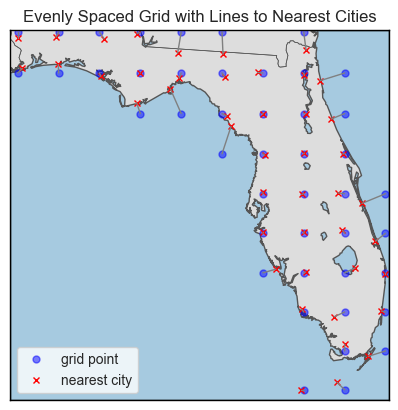

In [9]:
min_lat = min(FL_cities['lat'])
max_lat = max(FL_cities['lat'])

min_lon = min(FL_cities['lon'])
max_lon = max(FL_cities['lon'])

# Generate grid points
latitudes = np.linspace(min_lat, max_lat, 10)
longitudes = np.linspace(min_lon,max_lon, 10)

# Create mesh grid
lat_grid, lon_grid = np.meshgrid(latitudes, longitudes)

# Create a Basemap instance for Florida
m = Basemap(projection='merc', llcrnrlat=24.396308, llcrnrlon=-87.625000,
            urcrnrlat=31.000888, urcrnrlon=-79.974306, resolution='i')

# Set the color scheme
m.drawmapboundary(fill_color='#A6CAE0')  # Light blue for water
m.fillcontinents(color='#DDDDDD', lake_color='#A6CAE0')  # Light grey for land
m.drawcoastlines(color='#555555')  # Darker grey for coastlines
m.drawcountries(color='#555555')  # Darker grey for country borders
m.drawstates(color='#555555')  # Darker grey for state borders

# Plot each point in the grid
counter = 0
ll_list = []
for lat, lon in zip(np.ravel(lat_grid), np.ravel(lon_grid)):
    
    ## get the nearest city
    nearest_lat, nearest_lon, distance = nearest_city(lat,lon,FL_cities)
    #nearest_lat = FL_cities[FL_cities['city']==city]['lat'].values[0]
    #nearest_lon = FL_cities[FL_cities['city']==city]['lon'].values[0]

    x_grid, y_grid = m(lon, lat)
    x_nearest, y_nearest = m(nearest_lon, nearest_lat)

    ## keep grid points within 37 miles of city.
    ## this distance was tuned to yield exactly 45 cities
    if distance < 37:
        ll_list.append([nearest_lat,nearest_lon])

        counter +=1
        
        # Plot the grid point
        if counter == 1:
            m.plot(x_grid, y_grid, 'bo', markersize=5, alpha=0.5, label = 'grid point')
            m.plot(x_nearest, y_nearest, 'rx', markersize=5, alpha=1, label = 'nearest city')
        else:
            m.plot(x_grid, y_grid, 'bo', markersize=5, alpha=0.5)
            m.plot(x_nearest, y_nearest, 'rx', markersize=5, alpha=1)

        # Draw a line between the grid point and the nearest city
        m.plot([x_grid, x_nearest], [y_grid, y_nearest], color='gray', linewidth=1)

print("Number of grid points = ", counter)

plt.title('Evenly Spaced Grid with Lines to Nearest Cities')
plt.legend()
#plt.savefig('grid_points_with_cities_and_legend.png', dpi=300)
plt.show()

## Randomize and get search results
- Query = "Gourmet Grocery Store"
- z = 12
- Type = "search"
- Returns a list of names, addresses, and place ids

#### Randomize

In [7]:
indices_to_search = []
for each in ll_list:
    city_lat = each[0]
    city_lon = each[1]
    indices_to_search.append(FL_cities[(FL_cities['lat']==city_lat) & (FL_cities['lon']==city_lon)].index.values[0])

grid_search_df = FL_cities.loc[indices_to_search].sample(frac=1).reset_index(drop=True)
grid_search_df

,city,county_name,state_id,population,density,zip,lat,lon,Zoom,ll
0,Bristol,Liberty,FL,6443,6.7,32321,30.26196,-84.98910,12z,"@30.26196,-84.9891,12z"
1,Lake City,Columbia,FL,16184,33.9,32055,30.27031,-82.62507,12z,"@30.27031,-82.62507,12z"
2,Lutz,Hillsborough,FL,27309,581.6,33558,28.15871,-82.51597,12z,"@28.15871,-82.51597,12z"
3,Lake Alfred,Polk,FL,8535,196.7,33850,28.11886,-81.73191,12z,"@28.11886,-81.73191,12z"
4,McDavid,Escambia,FL,3269,6.1,32568,30.87085,-87.46792,12z,"@30.87085,-87.46792,12z"
5,Day,Lafayette,FL,66,2332.5,32013,30.19366,-83.29116,12z,"@30.19366,-83.29116,12z"
6,Satsuma,Putnam,FL,5287,69.7,32189,29.54991,-81.64819,12z,"@29.54991,-81.64819,12z"
7,Archer,Alachua,FL,8640,36.3,32618,29.53789,-82.52295,12z,"@29.53789,-82.52295,12z"
8,Flagler Beach,Flagler,FL,8209,178.8,32136,29.45252,-81.14025,12z,"@29.45252,-81.14025,12z"
9,Bonifay,Holmes,FL,14135,20.6,32425,30.85538,-85.72225,12z,"@30.85538,-85.72225,12z"


#### Get Search Results

In [27]:
## Fixed query params
base_params = {
    'q':"Gourmet Grocery Store",
    'engine': "google_maps",
    'type': "search",
    'api_key':serp_api_key    
}

## Get search results for every location
place_records = []
search_number = 0
for ll in tqdm(grid_search_df['ll']):

    ## Hit the API w/ specific location
    place_result = serpapi.search(base_params,ll=ll)

    ## Convert to dataframe and parse
    place_result_df = pd.DataFrame(place_result['local_results'])
    place_result_df.rename(columns={'title':'Name','type':'Type','description':'Description','position':'Search Position','reviews':'Reviews','rating':'Avg Rating','address':'Address','phone':'Phone'},inplace=True)
    place_result_df['query_coords'] = ll
    place_result_df['search_number'] = search_number
    search_number += 1

    ## Append dataframe to results
    place_records.append(place_result_df[['Name','Address','Phone','website','place_id','Search Position','query_coords','search_number']])

search_results_df = pd.concat(place_records, ignore_index=True).drop_duplicates('place_id').reset_index(drop=True)
search_results_df

  0%|          | 0/45 [00:00<?, ?it/s]

,Name,Address,Phone,website,place_id,Search Position,query_coords,search_number
0,Gourmet Deli,"4984 Palm Coast Pkwy NW Unit3, Palm Coast, FL ...",(386) 627-1687,http://gourmetdeli.us/?utm_source=gmb&utm_medi...,ChIJzfzIQ3WT5ogRx7CQ2SGGauc,1,"@29.45252,-81.14025,12z",0
1,Winn-Dixie,"1260 Palm Coast Pkwy NE, Palm Coast, FL 32137",(386) 446-4774,https://www.winndixie.com/,ChIJh_voj12U5ogR6oA5TlxSJms,2,"@29.45252,-81.14025,12z",0
2,Harris Grocery,"1006 S State St, Bunnell, FL 32110",(386) 437-3813,NaN,ChIJ1RILM5Hs5ogR2WO7PNCbhKg,3,"@29.45252,-81.14025,12z",0
3,East Coast Oriental Market,"4984 Palm Coast Pkwy NW suite 1&2, Palm Coast,...",(386) 302-0038,NaN,ChIJob-tOIeT5ogRm14jiLZP4xA,4,"@29.45252,-81.14025,12z",0
4,International Food,"300 S Central Ave #102, Flagler Beach, FL 32136",(386) 439-3697,NaN,ChIJvRzv4GTA5ogRv4vwNIJDLWo,5,"@29.45252,-81.14025,12z",0
...,...,...,...,...,...,...,...,...
594,CK Feed & Supply,"32461, 31 Main St, Rosemary Beach, FL 32461",(850) 588-0908,http://ckfeedandsupply.com/,ChIJVX82l_7xk4gRygIasd23sR4,18,"@30.20276,-85.7912,12z",43
595,Paparazzi Gourmet Deli,"2810 Thomas Dr, Panama City Beach, FL 32408",(850) 588-8244,http://www.paparazzigourmetdeli.com/,ChIJ6dMLNuyHk4gRWt6qQdxV63Y,20,"@30.20276,-85.7912,12z",43
596,Cowgills Hot Sauce,"1157 Neck Rd, Ponte Vedra Beach, FL 32082",(904) 285-5954,http://www.cowgillshotsauce.com/,ChIJizSsRDQ35IgRd4HOjvh-lW0,2,"@30.12488,-81.36577,12z",44
597,ALDI,"9041 Southside Blvd Unit118, Jacksonville, FL ...",(855) 955-2534,https://stores.aldi.us/fl/jacksonville/9041-so...,ChIJz5sP1xHL5YgR66dlcf1oy7U,5,"@30.12488,-81.36577,12z",44


In [29]:
search_results_df.to_csv('search_results_grid_search_45_z12_p1.csv',index=False)
print("DONE")

DONE


In [9]:
search_results_df = pd.read_csv('Data/Search Results/search_results_grid_search_45_z12_p1.csv')
search_results_df

,Name,Address,Phone,website,place_id,Search Position,query_coords,search_number
0,Gourmet Deli,"4984 Palm Coast Pkwy NW Unit3, Palm Coast, FL ...",(386) 627-1687,http://gourmetdeli.us/?utm_source=gmb&utm_medi...,ChIJzfzIQ3WT5ogRx7CQ2SGGauc,1,"@29.45252,-81.14025,12z",0
1,Winn-Dixie,"1260 Palm Coast Pkwy NE, Palm Coast, FL 32137",(386) 446-4774,https://www.winndixie.com/,ChIJh_voj12U5ogR6oA5TlxSJms,2,"@29.45252,-81.14025,12z",0
2,Harris Grocery,"1006 S State St, Bunnell, FL 32110",(386) 437-3813,NaN,ChIJ1RILM5Hs5ogR2WO7PNCbhKg,3,"@29.45252,-81.14025,12z",0
3,East Coast Oriental Market,"4984 Palm Coast Pkwy NW suite 1&2, Palm Coast,...",(386) 302-0038,NaN,ChIJob-tOIeT5ogRm14jiLZP4xA,4,"@29.45252,-81.14025,12z",0
4,International Food,"300 S Central Ave #102, Flagler Beach, FL 32136",(386) 439-3697,NaN,ChIJvRzv4GTA5ogRv4vwNIJDLWo,5,"@29.45252,-81.14025,12z",0
...,...,...,...,...,...,...,...,...
594,CK Feed & Supply,"32461, 31 Main St, Rosemary Beach, FL 32461",(850) 588-0908,http://ckfeedandsupply.com/,ChIJVX82l_7xk4gRygIasd23sR4,18,"@30.20276,-85.7912,12z",43
595,Paparazzi Gourmet Deli,"2810 Thomas Dr, Panama City Beach, FL 32408",(850) 588-8244,http://www.paparazzigourmetdeli.com/,ChIJ6dMLNuyHk4gRWt6qQdxV63Y,20,"@30.20276,-85.7912,12z",43
596,Cowgills Hot Sauce,"1157 Neck Rd, Ponte Vedra Beach, FL 32082",(904) 285-5954,http://www.cowgillshotsauce.com/,ChIJizSsRDQ35IgRd4HOjvh-lW0,2,"@30.12488,-81.36577,12z",44
597,ALDI,"9041 Southside Blvd Unit118, Jacksonville, FL ...",(855) 955-2534,https://stores.aldi.us/fl/jacksonville/9041-so...,ChIJz5sP1xHL5YgR66dlcf1oy7U,5,"@30.12488,-81.36577,12z",44


## Calculate cost

In [10]:
value_counts = search_results_df['search_number'].value_counts(sort=True)
cumulative_place_df = pd.DataFrame(value_counts.sort_index().cumsum()).reset_index()
cumulative_place_df.rename(columns={'search_number':'Search Number','count':'New Places'},inplace=True)
cumulative_place_df['Cost ($)'] = cumulative_place_df['Search Number']*0.01
cumulative_place_df

,Search Number,New Places,Cost ($)
0,0,20,0.00
1,1,40,0.01
2,2,55,0.02
3,3,75,0.03
4,4,91,0.04
5,5,106,0.05
6,6,123,0.06
7,7,140,0.07
8,8,158,0.08
9,9,178,0.09


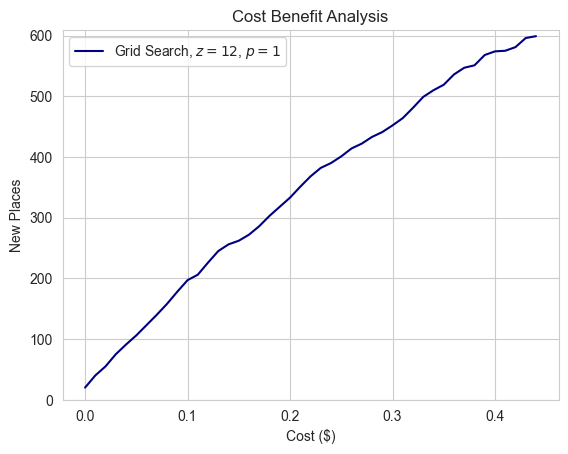

In [11]:
sns.lineplot(data=cumulative_place_df,x='Cost ($)',y='New Places',color='navy',label=r'Grid Search, $z = 12$, $p = 1$')
plt.ylim((0,np.max(cumulative_place_df['New Places']+10)))
plt.title('Cost Benefit Analysis')
#plt.savefig('grid_search_z12_p1.png',dpi=300)
plt.show()

## The cost here seems to plateau a bit at the end
- Not all of these places may be good
- Need to check this against gourmet food stores
- Ratings > 4.5 will serve as proxy for full GPT analysis, since that would incur it's own costs

## Flesh out details using the place ID and the maps API
- Maps API
- type = "places"
- Parse reviews, website, email, etc.

#### Helper function to simplify JSON data

In [12]:
## Define function to simplify JSONs
def simplify_json_data(data, fields):
    """
    Simplify a list of JSON objects by keeping only specified fields.

    :param data: List of dictionaries (JSON objects).
    :param fields: List of strings representing the keys to keep.
    :return: List of simplified dictionaries with only the specified fields.
    """
    simplified_data = []
    for item in data:
        simplified_item = {field: item[field] for field in fields if field in item}
        simplified_data.append(simplified_item)
    return simplified_data

#### Add information from google maps

In [18]:
## Initialize an empty list to hold all records
records = []

## Iterate through each place_id
for place_id in tqdm(search_results_df['place_id']):
    
    ## Hit the Google Maps API
    place_result = serpapi.search(engine="google_maps", place_id=place_id, api_key=serp_api_key)
    extensions = place_result['place_results'].get('extensions', [])

    ## Parse results and store in a dictionary
    record = {
        'Name': place_result['place_results'].get('title', ''),
        'Place ID':place_id,
        'Description': place_result['place_results'].get('description', ''),
        'Website': place_result['place_results'].get('website', ''),
        'Address': place_result['place_results'].get('address', ''),
        'Phone': place_result['place_results'].get('phone', ''),
        'Rating': place_result['place_results'].get('rating', ''),
        'Price': place_result['place_results'].get('price', ''),
        'Type': place_result['place_results'].get('type', ''),
        'Highlights':next((item.get('highlights', ['']) for item in extensions if 'highlights' in item), ['']),
        'Offerings':next((item.get('offerings', ['']) for item in extensions if 'offerings' in item), ['']),
        'Q_and_A': simplify_json_data(place_result['place_results'].get('questions_and_answers', []), ['question', 'answer']),
        'Snippets': place_result['place_results'].get('user_reviews', {}).get('summary', ''),
        'Reviews_Most_Relevant': simplify_json_data(place_result['place_results'].get('user_reviews', {}).get('most_relevant', []), ['username', 'rating', 'description', 'date'])
    }

    ## Append the record to the list
    records.append(record)

## Convert the list of dictionaries to a DataFrame
place_data_df = pd.DataFrame(records)
place_data_df

  0%|          | 0/599 [00:00<?, ?it/s]

,Name,Place ID,Description,Website,Address,Phone,Rating,Price,Type,Highlights,Offerings,Q_and_A,Snippets,Reviews_Most_Relevant
0,Gourmet Deli,ChIJzfzIQ3WT5ogRx7CQ2SGGauc,,http://gourmetdeli.us/?utm_source=gmb&utm_medi...,"4984 Palm Coast Pkwy NW Unit3, Palm Coast, FL ...",(386) 627-1687,4.7,,"[Deli, Russian grocery store]",[],[],[{'question': {'user': {'name': 'Carol Aldinge...,"[{'snippet': '""But also make a variety of soup...","[{'username': 'Damir Armstrong', 'rating': 5, ..."
1,Winn-Dixie,ChIJh_voj12U5ogR6oA5TlxSJms,,https://www.winndixie.com/,"1260 Palm Coast Pkwy NE, Palm Coast, FL 32137",(386) 446-4774,4.3,$,[Grocery store],[Great produce],[],[{'question': {'user': {'name': 'People are as...,"[{'snippet': '""Great prices, good selections o...",[{'username': 'Scotty Augustine Fennell-Rodrig...
2,Harris Grocery,ChIJ1RILM5Hs5ogR2WO7PNCbhKg,,,"1006 S State St, Bunnell, FL 32110",(386) 437-3813,4.6,,"[Grocery store, Supermarket]",[Great produce],[],"[{'question': {'user': {'name': 'Fred Littau',...","[{'snippet': '""Good place to shop for low pric...","[{'username': 'Deborah Shuls', 'rating': 5, 'd..."
3,East Coast Oriental Market,ChIJob-tOIeT5ogRm14jiLZP4xA,,,"4984 Palm Coast Pkwy NW suite 1&2, Palm Coast,...",(386) 302-0038,4.5,,[Asian grocery store],[Great produce],[],[{'question': {'user': {'name': 'Kristine Stol...,"[{'snippet': '""If you like cooking Thai, Vietn...","[{'username': 'Tamika Mctavish', 'rating': 4, ..."
4,International Food,ChIJvRzv4GTA5ogRv4vwNIJDLWo,,,"300 S Central Ave #102, Flagler Beach, FL 32136",(386) 439-3697,4.1,,[Grocery store],[],[],[],"[{'snippet': '""Lots of eastern European food a...","[{'username': 'Move INN', 'rating': 5, 'descri..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594,CK Feed & Supply,ChIJVX82l_7xk4gRygIasd23sR4,,http://ckfeedandsupply.com/,"32461, 31 Main St, Rosemary Beach, FL 32461",(850) 588-0908,3.8,,"[Gourmet grocery store, Natural goods store, W...",[],[],[],"[{'snippet': '""Great staff .wine ice cream .et...","[{'username': 'Gaynelle Khan', 'rating': 5, 'd..."
595,Paparazzi Gourmet Deli,ChIJ6dMLNuyHk4gRWt6qQdxV63Y,,http://www.paparazzigourmetdeli.com/,"2810 Thomas Dr, Panama City Beach, FL 32408",(850) 588-8244,4.6,$$,"[Italian restaurant, Deli, Dessert shop, Itali...",[Fast service],"[Alcohol, Beer, Coffee, Comfort food, Quick bi...",[{'question': {'user': {'name': 'David Tripoli...,"[{'snippet': '""This is an excellent place to g...","[{'username': 'Angie Wood', 'rating': 5, 'desc..."
596,Cowgills Hot Sauce,ChIJizSsRDQ35IgRd4HOjvh-lW0,,http://www.cowgillshotsauce.com/,"1157 Neck Rd, Ponte Vedra Beach, FL 32082",(904) 285-5954,4.8,,"[Gourmet grocery store, Condiments supplier, F...",[],[],[{'question': {'user': {'name': 'Karey Stratfo...,"[{'snippet': '""Great customer service and an a...","[{'username': 'Glynnis Moreland', 'rating': 3,..."
597,ALDI,ChIJz5sP1xHL5YgR66dlcf1oy7U,"Retail chain selling a range of grocery items,...",https://stores.aldi.us/fl/jacksonville/9041-so...,"9041 Southside Blvd Unit118, Jacksonville, FL ...",(855) 955-2534,4.6,$,"[Supermarket, Grocery store]",[Great produce],[Organic products],"[{'question': {'user': {'name': 'Carol Daley',...","[{'snippet': '""Good prices on veggies, milk, e...","[{'username': 'Noel Lovell-Moore', 'rating': 5..."


#### Export results

In [19]:
place_data_df.to_csv('place_data_df_new_big_600.csv',index=False)
print("DONE")

DONE


## Check the Quality

#### Join back to search result

In [32]:
search_results_short = search_results_df[['place_id','search_number']]
search_results_short

,place_id,search_number
0,ChIJzfzIQ3WT5ogRx7CQ2SGGauc,0
1,ChIJh_voj12U5ogR6oA5TlxSJms,0
2,ChIJ1RILM5Hs5ogR2WO7PNCbhKg,0
3,ChIJob-tOIeT5ogRm14jiLZP4xA,0
4,ChIJvRzv4GTA5ogRv4vwNIJDLWo,0
...,...,...
594,ChIJVX82l_7xk4gRygIasd23sR4,43
595,ChIJ6dMLNuyHk4gRWt6qQdxV63Y,43
596,ChIJizSsRDQ35IgRd4HOjvh-lW0,44
597,ChIJz5sP1xHL5YgR66dlcf1oy7U,44


## Filter to > 4.5 Stars in FL

,Name,Place ID,Description,Website,Address,Phone,Rating,Price,Type,Highlights,Offerings,Q_and_A,Snippets,Reviews_Most_Relevant,search_number,State
0,Gourmet Deli,ChIJzfzIQ3WT5ogRx7CQ2SGGauc,,http://gourmetdeli.us/?utm_source=gmb&utm_medi...,"4984 Palm Coast Pkwy NW Unit3, Palm Coast, FL ...",(386) 627-1687,4.7,,"[Deli, Russian grocery store]",[],[],[{'question': {'user': {'name': 'Carol Aldinge...,"[{'snippet': '""But also make a variety of soup...","[{'username': 'Damir Armstrong', 'rating': 5, ...",0,FL
2,Harris Grocery,ChIJ1RILM5Hs5ogR2WO7PNCbhKg,,,"1006 S State St, Bunnell, FL 32110",(386) 437-3813,4.6,,"[Grocery store, Supermarket]",[Great produce],[],"[{'question': {'user': {'name': 'Fred Littau',...","[{'snippet': '""Good place to shop for low pric...","[{'username': 'Deborah Shuls', 'rating': 5, 'd...",0,FL
3,East Coast Oriental Market,ChIJob-tOIeT5ogRm14jiLZP4xA,,,"4984 Palm Coast Pkwy NW suite 1&2, Palm Coast,...",(386) 302-0038,4.5,,[Asian grocery store],[Great produce],[],[{'question': {'user': {'name': 'Kristine Stol...,"[{'snippet': '""If you like cooking Thai, Vietn...","[{'username': 'Tamika Mctavish', 'rating': 4, ...",0,FL
5,Millennium Grocery,ChIJuZLyf06U5ogRimUsYk3KQ5o,,http://instagram.com/millenniumgrocery,"9 Palm Harbor Village Way W # F, Palm Coast, F...",(386) 283-5618,4.8,,[Grocery store],[],[],[{'question': {'user': {'name': 'Yenny Alvaren...,"[{'snippet': '""Top, wide variety of Portuguese...","[{'username': 'David Castanheira', 'rating': 5...",0,FL
6,Grace's Market,ChIJN9f8ge6V5ogRU5yKyZgMi0g,,,"1 Florida Park Dr N, Palm Coast, FL 32137",(386) 447-3636,4.6,,"[Grocery store, Deli, Portuguese restaurant, S...",[Great produce],[],[],"[{'snippet': '""The owners are very nice and po...","[{'username': 'Sandra Pires', 'rating': 5, 'de...",0,FL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
592,30A Olive Oil Co,ChIJwfyNAgHyk4gRLpfqvaCuC5U,,http://30aoliveoil.com/,"12805 US-98 Suite N 101, Inlet Beach, FL 32461",(850) 909-0099,4.9,,"[Gourmet grocery store, Coffee shop, Olive oil...",[],[],"[{'question': {'user': {'name': 'Alton Gates',...","[{'snippet': '""The location is wonderful and c...","[{'username': 'Hanieh hosseini', 'rating': 5, ...",43,FL
595,Paparazzi Gourmet Deli,ChIJ6dMLNuyHk4gRWt6qQdxV63Y,,http://www.paparazzigourmetdeli.com/,"2810 Thomas Dr, Panama City Beach, FL 32408",(850) 588-8244,4.6,$$,"[Italian restaurant, Deli, Dessert shop, Itali...",[Fast service],"[Alcohol, Beer, Coffee, Comfort food, Quick bi...",[{'question': {'user': {'name': 'David Tripoli...,"[{'snippet': '""This is an excellent place to g...","[{'username': 'Angie Wood', 'rating': 5, 'desc...",43,FL
596,Cowgills Hot Sauce,ChIJizSsRDQ35IgRd4HOjvh-lW0,,http://www.cowgillshotsauce.com/,"1157 Neck Rd, Ponte Vedra Beach, FL 32082",(904) 285-5954,4.8,,"[Gourmet grocery store, Condiments supplier, F...",[],[],[{'question': {'user': {'name': 'Karey Stratfo...,"[{'snippet': '""Great customer service and an a...","[{'username': 'Glynnis Moreland', 'rating': 3,...",44,FL
597,ALDI,ChIJz5sP1xHL5YgR66dlcf1oy7U,"Retail chain selling a range of grocery items,...",https://stores.aldi.us/fl/jacksonville/9041-so...,"9041 Southside Blvd Unit118, Jacksonville, FL ...",(855) 955-2534,4.6,$,"[Supermarket, Grocery store]",[Great produce],[Organic products],"[{'question': {'user': {'name': 'Carol Daley',...","[{'snippet': '""Good prices on veggies, milk, e...","[{'username': 'Noel Lovell-Moore', 'rating': 5...",44,FL


#### Repeat the cumulative count

In [78]:
rated_value_counts = rated_search_results['search_number'].value_counts(sort=True)
rated_cumulative_place_df = pd.DataFrame(rated_value_counts.sort_index().cumsum()).reset_index()
rated_cumulative_place_df.rename(columns={'search_number':'Search Number','count':'> 4.5 Star'},inplace=True)
rated_cumulative_place_df['Cost ($)'] = rated_cumulative_place_df['Search Number']*0.01
rated_cumulative_place_df

,Search Number,> 4.5 Star,Cost ($)
0,0,15,0.00
1,1,27,0.01
2,2,37,0.02
3,3,43,0.03
4,4,45,0.04
5,5,56,0.05
6,6,65,0.06
7,7,70,0.07
8,8,79,0.08
9,9,89,0.09


## Join rated to non-rated

In [79]:
new_place_count = pd.merge(cumulative_place_df,rated_cumulative_place_df.drop('Cost ($)',axis=1),how='left',on='Search Number')
new_place_count

,Search Number,New Places,Cost ($),> 4.5 Star
0,0,20,0.00,15.0
1,1,40,0.01,27.0
2,2,55,0.02,37.0
3,3,75,0.03,43.0
4,4,91,0.04,45.0
5,5,106,0.05,56.0
6,6,123,0.06,65.0
7,7,140,0.07,70.0
8,8,158,0.08,79.0
9,9,178,0.09,89.0


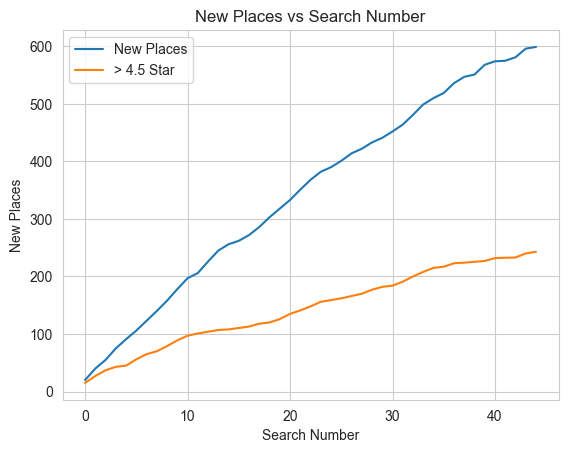

In [82]:
sns.lineplot(data=new_place_count,x='Search Number',y='New Places',label='New Places')
sns.lineplot(data=new_place_count,x='Search Number',y='> 4.5 Star',label='> 4.5 Star')

#plt.ylim((0,np.max(rated_cumulative_place_df['New Places']+10)))
#plt.ylim((0,np.max(rated_cumulative_place_df['New Places']+10)))

plt.title('New Places vs Search Number')
#plt.savefig('grid_search_z12_p1.png',dpi=300)
plt.show()

### Plot cost per new result

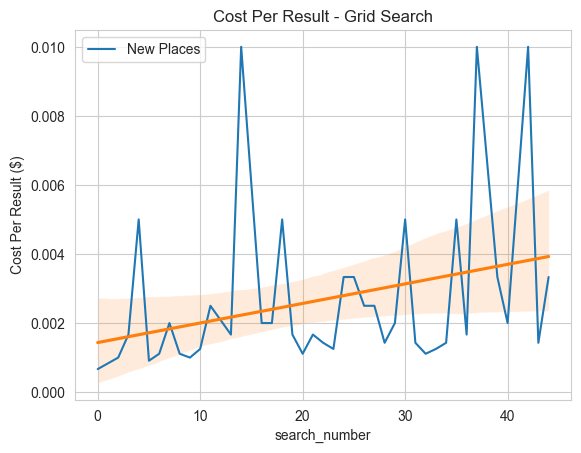

In [97]:
cost_per_result_df = pd.DataFrame(rated_search_results['search_number'].value_counts(sort=True)).reset_index()
cost_per_result_df['Cost Per Result ($)'] = 0.01/temp['count']
sns.lineplot(data=cost_per_result_df,x='search_number',y='Cost Per Result ($)',label='New Places')
sns.regplot(x='search_number', y='Cost Per Result ($)', data=cost_per_result_df, scatter=False)
plt.title('Cost Per Result - Grid Search')
#plt.savefig('grid_search_z12_p1.png',dpi=300)
plt.show()

## It's getting more expensive, but we haven't plateued
- 243 high quality results

## Let's try pagination
- We had 600 places
- Let's get the next 600

In [114]:
## Fixed query params
base_params = {
    'q':"Gourmet Grocery Store",
    'engine': "google_maps",
    'type': "search",
    'start':20,
    'api_key':serp_api_key    
}

## Get search results for every location
place_records = []
search_number = 0
for ll in tqdm(grid_search_df['ll']):

    ## Hit the API w/ specific location
    place_result = serpapi.search(base_params,ll=ll)

    ## Convert to dataframe and parse
    place_result_df = pd.DataFrame(place_result['local_results'])
    place_result_df.rename(columns={'title':'Name','type':'Type','description':'Description','position':'Search Position','reviews':'Reviews','rating':'Avg Rating','address':'Address','phone':'Phone'},inplace=True)
    place_result_df['query_coords'] = ll
    place_result_df['search_number'] = search_number
    search_number += 1

    ## Append dataframe to results
    place_records.append(place_result_df[['Name','Address','Phone','website','place_id','Search Position','query_coords','search_number']])

search_results_page2_df = pd.concat(place_records, ignore_index=True).drop_duplicates('place_id').reset_index(drop=True)
search_results_page2_df

  0%|          | 0/45 [00:00<?, ?it/s]

,Name,Address,Phone,website,place_id,Search Position,query_coords,search_number
0,Dollar General,"15827 FL-71, Blountstown, FL 32424",(850) 394-9290,https://www.dollargeneral.com/store-directory/...,ChIJ5TOf5IRJk4gRUgfTRTqSCOs,1,"@30.26196,-84.9891,12z",0
1,The Local Exchange,"130 S Park Square NE, Marietta, GA 30060",(770) 794-3136,http://www.thelocalexchangemarietta.com/,ChIJJUqfiSQU9YgRTtFti4d7aEE,2,"@30.26196,-84.9891,12z",0
2,Paradise International Food,"11309 Starkey Rd, Largo, FL 33773",(727) 873-3950,NaN,ChIJq4dqAeL6wogRqcTFgceKftI,3,"@30.26196,-84.9891,12z",0
3,Trader Joe's,"131 Orlando Ave, Winter Park, FL 32789",(407) 622-0874,https://locations.traderjoes.com/fl/winter-par...,ChIJ9x3SuW1w54gRIm5vfdDdcpw,4,"@30.26196,-84.9891,12z",0
4,International Food,"13201 Tamiami Trail, North Port, FL 34287",(941) 429-1239,NaN,ChIJs0LPoYZUw4gRp7cciPJmxqk,5,"@30.26196,-84.9891,12z",0
...,...,...,...,...,...,...,...,...
616,Sunrise Food,"5406 Plymouth St, Jacksonville, FL 32205",(904) 783-8362,NaN,ChIJKyC_7Pm45YgRvL5cfN_lKno,16,"@30.65851,-81.64478,12z",44
617,Knyaw grocery,"5800 Beach Blvd suit 103, Jacksonville, FL 32207",NaN,NaN,ChIJnQ6KeYe35YgR_JQPeSui4Ek,17,"@30.65851,-81.64478,12z",44
618,1st & Huron Food Store/Deli & Smoke Shop,"1098 Huron St, Jacksonville, FL 32254",(904) 367-2939,https://www.facebook.com/profile.php?id=100067...,ChIJE2BFwYq55YgRNNCWFMpIjJU,18,"@30.65851,-81.64478,12z",44
619,A & E Grocery,"1500 Florida Ave, Jacksonville, FL 32206",(904) 425-0892,NaN,ChIJ17vpTte25YgRzAA5duvh6lE,19,"@30.65851,-81.64478,12z",44


## I can join on search number, right?
- I can just concat, then when I group by search number it'll all work out

In [122]:
search_results_df['Page Number'] = 1
search_results_page2_df['Page Number'] = 2
search_results_two_page = pd.concat([search_results_df,search_results_page2_df]).drop_duplicates(subset='place_id')
search_results_two_page

,Name,Address,Phone,website,place_id,Search Position,query_coords,search_number,Page Number
0,Gourmet Deli,"4984 Palm Coast Pkwy NW Unit3, Palm Coast, FL ...",(386) 627-1687,http://gourmetdeli.us/?utm_source=gmb&utm_medi...,ChIJzfzIQ3WT5ogRx7CQ2SGGauc,1,"@29.45252,-81.14025,12z",0,1
1,Winn-Dixie,"1260 Palm Coast Pkwy NE, Palm Coast, FL 32137",(386) 446-4774,https://www.winndixie.com/,ChIJh_voj12U5ogR6oA5TlxSJms,2,"@29.45252,-81.14025,12z",0,1
2,Harris Grocery,"1006 S State St, Bunnell, FL 32110",(386) 437-3813,NaN,ChIJ1RILM5Hs5ogR2WO7PNCbhKg,3,"@29.45252,-81.14025,12z",0,1
3,East Coast Oriental Market,"4984 Palm Coast Pkwy NW suite 1&2, Palm Coast,...",(386) 302-0038,NaN,ChIJob-tOIeT5ogRm14jiLZP4xA,4,"@29.45252,-81.14025,12z",0,1
4,International Food,"300 S Central Ave #102, Flagler Beach, FL 32136",(386) 439-3697,NaN,ChIJvRzv4GTA5ogRv4vwNIJDLWo,5,"@29.45252,-81.14025,12z",0,1
...,...,...,...,...,...,...,...,...,...
612,Jekyll Market,"11 Main St, Jekyll Island, GA 31527",(912) 635-2253,http://www.jekyllmarket.com/,ChIJAQEWYxbc5IgRqxxV1MlvsBU,11,"@30.65851,-81.64478,12z",44,2
614,The Superette,"1701 N Pearl St, Jacksonville, FL 32206",(904) 356-2531,NaN,ChIJeRBrKzC35YgR4YPbep116VM,13,"@30.65851,-81.64478,12z",44,2
615,Community Food Store,"5606 Buffalo Ave, Jacksonville, FL 32208",NaN,NaN,ChIJN59EEyKx5YgRurNWHaJApz8,15,"@30.65851,-81.64478,12z",44,2
618,1st & Huron Food Store/Deli & Smoke Shop,"1098 Huron St, Jacksonville, FL 32254",(904) 367-2939,https://www.facebook.com/profile.php?id=100067...,ChIJE2BFwYq55YgRNNCWFMpIjJU,18,"@30.65851,-81.64478,12z",44,2


## Add maps information

In [124]:
## Initialize an empty list to hold all records
records = []

## Iterate through each place_id
for place_id in tqdm(search_results_two_page['place_id']):
    
    ## Hit the Google Maps API
    place_result = serpapi.search(engine="google_maps", place_id=place_id, api_key=serp_api_key)
    extensions = place_result['place_results'].get('extensions', [])

    ## Parse results and store in a dictionary
    record = {
        'Name': place_result['place_results'].get('title', ''),
        'Place ID':place_id,
        'Description': place_result['place_results'].get('description', ''),
        'Website': place_result['place_results'].get('website', ''),
        'Address': place_result['place_results'].get('address', ''),
        'Phone': place_result['place_results'].get('phone', ''),
        'Rating': place_result['place_results'].get('rating', ''),
        'Price': place_result['place_results'].get('price', ''),
        'Type': place_result['place_results'].get('type', ''),
        'Highlights':next((item.get('highlights', ['']) for item in extensions if 'highlights' in item), ['']),
        'Offerings':next((item.get('offerings', ['']) for item in extensions if 'offerings' in item), ['']),
        'Q_and_A': simplify_json_data(place_result['place_results'].get('questions_and_answers', []), ['question', 'answer']),
        'Snippets': place_result['place_results'].get('user_reviews', {}).get('summary', ''),
        'Reviews_Most_Relevant': simplify_json_data(place_result['place_results'].get('user_reviews', {}).get('most_relevant', []), ['username', 'rating', 'description', 'date'])
    }

    ## Append the record to the list
    records.append(record)

## Convert the list of dictionaries to a DataFrame
place_data_df = pd.DataFrame(records)
place_data_df

  0%|          | 0/1007 [00:00<?, ?it/s]

,Name,Place ID,Description,Website,Address,Phone,Rating,Price,Type,Highlights,Offerings,Q_and_A,Snippets,Reviews_Most_Relevant
0,Gourmet Deli,ChIJzfzIQ3WT5ogRx7CQ2SGGauc,,http://gourmetdeli.us/?utm_source=gmb&utm_medi...,"4984 Palm Coast Pkwy NW Unit3, Palm Coast, FL ...",(386) 627-1687,4.7,,"[Deli, Russian grocery store]",[],[],[{'question': {'user': {'name': 'Carol Aldinge...,"[{'snippet': '""But also make a variety of soup...","[{'username': 'Damir Armstrong', 'rating': 5, ..."
1,Winn-Dixie,ChIJh_voj12U5ogR6oA5TlxSJms,,https://www.winndixie.com/,"1260 Palm Coast Pkwy NE, Palm Coast, FL 32137",(386) 446-4774,4.3,$,[Grocery store],[Great produce],[],[{'question': {'user': {'name': 'People are as...,"[{'snippet': '""Great prices, good selections o...",[{'username': 'Scotty Augustine Fennell-Rodrig...
2,Harris Grocery,ChIJ1RILM5Hs5ogR2WO7PNCbhKg,,,"1006 S State St, Bunnell, FL 32110",(386) 437-3813,4.6,,"[Grocery store, Supermarket]",[Great produce],[],"[{'question': {'user': {'name': 'Fred Littau',...","[{'snippet': '""Good place to shop for low pric...","[{'username': 'Michael Haddix', 'rating': 4, '..."
3,East Coast Oriental Market,ChIJob-tOIeT5ogRm14jiLZP4xA,,,"4984 Palm Coast Pkwy NW suite 1&2, Palm Coast,...",(386) 302-0038,4.5,,[Asian grocery store],[Great produce],[],[{'question': {'user': {'name': 'Kristine Stol...,"[{'snippet': '""If you like cooking Thai, Vietn...","[{'username': 'Tamika Mctavish', 'rating': 4, ..."
4,International Food,ChIJvRzv4GTA5ogRv4vwNIJDLWo,,,"300 S Central Ave #102, Flagler Beach, FL 32136",(386) 439-3697,4.1,,[Grocery store],[],[],[],"[{'snippet': '""Lots of eastern European food a...","[{'username': 'Move INN', 'rating': 5, 'descri..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1002,Jekyll Market,ChIJAQEWYxbc5IgRqxxV1MlvsBU,,http://www.jekyllmarket.com/,"11 Main St, Jekyll Island, GA 31527",(912) 635-2253,4.4,,"[Gourmet grocery store, Grocery store, Market,...",[Great produce],[],[{'question': {'user': {'name': 'Jasmine York'...,"[{'snippet': '""They offer a wide choice of pro...","[{'username': 'Maria Luisa Lissarrague', 'rati..."
1003,The Superette,ChIJeRBrKzC35YgR4YPbep116VM,,,"1701 N Pearl St, Jacksonville, FL 32206",(904) 356-2531,4.6,,"[Grocery store, Supermarket]",[Great produce],[],[],"[{'snippet': '""Management and staff are very f...","[{'username': 'Mikeyya Brooks', 'rating': 5, '..."
1004,Community Food Store,ChIJN59EEyKx5YgRurNWHaJApz8,,,"5606 Buffalo Ave, Jacksonville, FL 32208",,4.1,,"[Grocery store, Convenience store]",[],[],[],"[{'snippet': '""Easy access and near work""'}, {...","[{'username': 'Lisa Daniels', 'rating': 3, 'de..."
1005,1st & Huron Food Store/Deli & Smoke Shop,ChIJE2BFwYq55YgRNNCWFMpIjJU,,https://www.facebook.com/profile.php?id=100067...,"1098 Huron St, Jacksonville, FL 32254",(904) 367-2939,4.4,,[Grocery store],[],[Prepared foods],[],"[{'snippet': '""They have the best prices plus ...","[{'username': 'Tyson Love', 'rating': 1, 'desc..."


In [125]:
place_data_df.to_csv('place_data_df_new_big_two_page_1007.csv',index=False)
print("DONE")

DONE


## Filter to FL > 4.5 Star

In [128]:
search_results_two_page_short = search_results_two_page[['place_id','search_number']]
search_results_two_page_short

,place_id,search_number
0,ChIJzfzIQ3WT5ogRx7CQ2SGGauc,0
1,ChIJh_voj12U5ogR6oA5TlxSJms,0
2,ChIJ1RILM5Hs5ogR2WO7PNCbhKg,0
3,ChIJob-tOIeT5ogRm14jiLZP4xA,0
4,ChIJvRzv4GTA5ogRv4vwNIJDLWo,0
...,...,...
612,ChIJAQEWYxbc5IgRqxxV1MlvsBU,44
614,ChIJeRBrKzC35YgR4YPbep116VM,44
615,ChIJN59EEyKx5YgRurNWHaJApz8,44
618,ChIJE2BFwYq55YgRNNCWFMpIjJU,44


#### Filter to FL > 4.5 star

In [131]:
rated_search_results_two_page = pd.merge(place_data_df,search_results_two_page_short,left_on='Place ID',right_on = 'place_id',how='left').drop('place_id',axis=1)
rated_search_results_two_page['Rating'] = pd.to_numeric(rated_search_results_two_page['Rating'], errors='coerce')
rated_search_results_two_page = rated_search_results_two_page[rated_search_results_two_page['Rating']>=4.5]
rated_search_results_two_page['State'] = rated_search_results_two_page['Address'].str.split(',',expand=True)[2].str.split(' ',expand=True)[1]
rated_search_results_two_page = rated_search_results_two_page[rated_search_results_two_page['State']=='FL']
rated_search_results_two_page

,Name,Place ID,Description,Website,Address,Phone,Rating,Price,Type,Highlights,Offerings,Q_and_A,Snippets,Reviews_Most_Relevant,search_number,State
0,Gourmet Deli,ChIJzfzIQ3WT5ogRx7CQ2SGGauc,,http://gourmetdeli.us/?utm_source=gmb&utm_medi...,"4984 Palm Coast Pkwy NW Unit3, Palm Coast, FL ...",(386) 627-1687,4.7,,"[Deli, Russian grocery store]",[],[],[{'question': {'user': {'name': 'Carol Aldinge...,"[{'snippet': '""But also make a variety of soup...","[{'username': 'Damir Armstrong', 'rating': 5, ...",0,FL
2,Harris Grocery,ChIJ1RILM5Hs5ogR2WO7PNCbhKg,,,"1006 S State St, Bunnell, FL 32110",(386) 437-3813,4.6,,"[Grocery store, Supermarket]",[Great produce],[],"[{'question': {'user': {'name': 'Fred Littau',...","[{'snippet': '""Good place to shop for low pric...","[{'username': 'Michael Haddix', 'rating': 4, '...",0,FL
3,East Coast Oriental Market,ChIJob-tOIeT5ogRm14jiLZP4xA,,,"4984 Palm Coast Pkwy NW suite 1&2, Palm Coast,...",(386) 302-0038,4.5,,[Asian grocery store],[Great produce],[],[{'question': {'user': {'name': 'Kristine Stol...,"[{'snippet': '""If you like cooking Thai, Vietn...","[{'username': 'Tamika Mctavish', 'rating': 4, ...",0,FL
5,Millennium Grocery,ChIJuZLyf06U5ogRimUsYk3KQ5o,,http://instagram.com/millenniumgrocery,"9 Palm Harbor Village Way W # F, Palm Coast, F...",(386) 283-5618,4.8,,[Grocery store],[],[],[{'question': {'user': {'name': 'Yenny Alvaren...,"[{'snippet': '""Top, wide variety of Portuguese...","[{'username': 'David Castanheira', 'rating': 5...",0,FL
6,Grace's Market,ChIJN9f8ge6V5ogRU5yKyZgMi0g,,,"1 Florida Park Dr N, Palm Coast, FL 32137",(386) 447-3636,4.6,,"[Grocery store, Deli, Portuguese restaurant, S...",[Great produce],[],[],"[{'snippet': '""The owners are very nice and po...","[{'username': 'Sandra Pires', 'rating': 5, 'de...",0,FL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,INDIA BAZAAR,ChIJ4aUPcsEp2YgRUKot6rpqFXw,,,"4780 Okeechobee Blvd, West Palm Beach, FL 33417",(561) 684-3480,4.5,$$,"[Indian grocery store, Food court, Fresh food ...",[Great produce],"[Organic products, Prepared foods]",[{'question': {'user': {'name': 'Lani Love and...,"[{'snippet': '""Wonderful selection of Indian s...","[{'username': 'Holly', 'rating': 5, 'descripti...",42,FL
994,The Honey Baked Ham Company,ChIJNV7gadwd24gRY3CJIsNQ_TQ,Family-owned chain selling ready-to-serve smok...,https://www.honeybaked.com/stores/328,"2275 Pine Ridge Rd Suite 101, Naples, FL 34109",(239) 596-2615,4.5,$$,"[Deli, Box lunch supplier, Caterer, Gift shop,...",[],[],"[{'question': {'user': {'name': 'Joy Carren', ...","[{'snippet': '""Busy time of year, bit quick fr...","[{'username': 'Erwin Gumapac', 'rating': 5, 'd...",43,FL
999,Europa Delicatessen,ChIJe4eb0Af_5IgRsm0SicPXkno,,https://europadelicatessen.business.site/?utm_...,"1016 S 14th St, Fernandina Beach, FL 32034",,4.9,,"[Deli, Butcher shop deli, European restaurant]",[],[],[{'question': {'user': {'name': 'Annette Jones...,"[{'snippet': '""Great variety of unique foods, ...","[{'username': 'Christopher Hughes', 'rating': ...",44,FL
1001,Smokehouse Meats of Fernandina Beach,ChIJhZjVXRNV5IgRpbAKEZdOvg0,,https://smokehousemeatsoffernandinabeach.busin...,"474347 State Rd 200, Fernandina Beach, FL 32034",(904) 775-5798,4.9,,[Butcher shop],[],[],"[{'question': {'user': {'name': 'Peggy Davis',...","[{'snippet': '""Awesome place, always great qua...","[{'username': 'mary mary', 'rating': 5, 'descr...",44,FL


In [132]:
rated_value_counts_two_page = rated_search_results_two_page['search_number'].value_counts(sort=True)
rated_cumulative_place_df_two_page = pd.DataFrame(rated_value_counts_two_page.sort_index().cumsum()).reset_index()
rated_cumulative_place_df_two_page.rename(columns={'search_number':'Search Number','count':'> 4.5 Star'},inplace=True)
rated_cumulative_place_df_two_page['Cost ($)'] = rated_cumulative_place_df_two_page['Search Number']*0.02
rated_cumulative_place_df_two_page

,Search Number,> 4.5 Star,Cost ($)
0,0,15,0.00
1,1,27,0.02
2,2,43,0.04
3,3,56,0.06
4,4,58,0.08
5,5,69,0.10
6,6,78,0.12
7,7,86,0.14
8,8,98,0.16
9,9,108,0.18


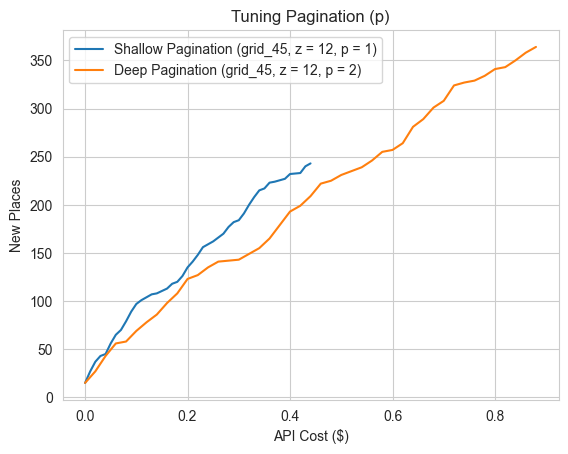

In [154]:
sns.lineplot(data=new_place_count,x='Cost ($)',y='> 4.5 Star',label='Shallow Pagination (grid_45, z = 12, p = 1)')
sns.lineplot(data=rated_cumulative_place_df_two_page,x='Cost ($)',y='> 4.5 Star',label='Deep Pagination (grid_45, z = 12, p = 2)')

#plt.ylim((0,np.max(rated_cumulative_place_df['New Places']+10)))
#plt.ylim((0,np.max(rated_cumulative_place_df['New Places']+10)))

plt.ylabel('New Places')
plt.xlabel('API Cost ($)')
plt.title('Tuning Pagination (p)')
plt.savefig('pagination_deep_vs_shallow_3.png',dpi=300)
plt.show()

## The cost per result is cheaper for the shallow pagination
- Let's try doubling the grid density and keeping shallow pagination
- This should allow us to keep getting high quality results

## Plot new results vs cost with and without pagination
- grid_45, z = 12, p = 1
- grid_45, z = 12, p = 2
- Going deeper should rise steeper and plateau earlier

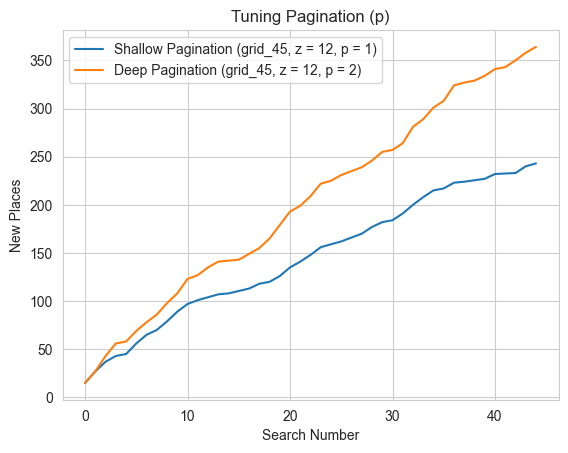

In [157]:
sns.lineplot(data=new_place_count,x='Search Number',y='> 4.5 Star',label='Shallow Pagination (grid_45, z = 12, p = 1)')
sns.lineplot(data=rated_cumulative_place_df_two_page,x='Search Number',y='> 4.5 Star',label='Deep Pagination (grid_45, z = 12, p = 2)')

#plt.ylim((0,np.max(rated_cumulative_place_df['New Places']+10)))
#plt.ylim((0,np.max(rated_cumulative_place_df['New Places']+10)))

plt.ylabel('New Places')
plt.xlabel('Search Number')
plt.title('Tuning Pagination (p)')
#plt.savefig('pagination_deep_vs_shallow_4.png',dpi=300)
plt.show()

## Export this data and keep trying to optimize search params
- We are at 364 good places

In [160]:
grid_45_z12_p2 = rated_cumulative_place_df_two_page
grid_45_z12_p2.to_csv('new_places_grid_45_z12_p2.csv')
print("DONE")

DONE


In [162]:
grid_45_z12_p1 = rated_cumulative_place_df
grid_45_z12_p1.to_csv('new_places_grid_45_z12_p1.csv')
print("DONE")

DONE


## Need a denser grid
- Also try rank ordering the cities my population and passing those lat+long directly